In [ ]:
# !pip install keras-core --upgrade
# !pip install -q keras-nlp
# !pip install seaborn

In [ ]:
# !pip install transformers

# Import the Libararies

In [ ]:
# !pip install pandas

In [ ]:
# !pip install tqdm

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import tensorflow as tf
# import keras_core as keras
# import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
# print("TensorFlow version:", tf.__version__)
import re
from tqdm.auto import tqdm
tqdm.pandas()
from tqdm import tqdm
# from sentence_transformers import SentenceTransformer
# from scipy.spatial.distance import cosine
import random
# print("Keras version:", keras.__version__)
# print("KerasNLP version:", keras_nlp.__version__)

# Load the data


In [ ]:
train_prompts = pd.read_csv ('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')  #('train_prompts.csv')
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')  #('train_essays.csv')
test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')  #('test_essays.csv')
train_extra = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv')  #('train_v3_drcat_01.csv')
train_extra_2 = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_02.csv')  #('train_v3_drcat_02.csv')
cleaned_text_3 = pd.read_csv('/kaggle/input/clean-data-set/cleaned_data_3_clean.csv')

# 🐝데이터 준비 (train+extra)

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="generated")

abs_values = train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [ ]:
train_essays['text_length'] = train_essays['text'].apply(lambda x: len(str(x)))

# 'text' 열을 문자열로 캐스팅하고 리스트로 변환
train_essays_sen = train_essays['text'].astype(str).tolist()

# 각 텍스트의 문장 수를 세어 새로운 열에 저장
train_essays['sentence_count'] = [text.count('.') + text.count('!') + text.count('?') for text in train_essays_sen]
# df_train_extra_stu.drop(['prompt_name','source','RDizzl3_seven','model'],axis=1,inplace=True)

train_essays.drop(['id','prompt_id'],axis=1,inplace=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the histogram
plt.figure(figsize=(12, 6))
sns.histplot(train_essays['text_length'], bins=50, color='blue', label='Generated 1 filter', kde=True)
plt.title('Distribution of Sentence Length by "generated 1 filter"')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
selected_rows11 = train_essays[train_essays['generated'] == 1]
selected_rows01 = train_essays[train_essays['generated'] == 0]
# 선택된 행들에 대해 describe를 수행합니다.
description11 = selected_rows11.describe()
description01 = selected_rows01.describe()

# 결과를 출력합니다.
print(description01)
print(description11)

In [ ]:
# 'generated' 열 값이 0인 경우와 1인 경우를 분리
generated_0_counts1 = train_essays[train_essays['generated'] == 0]['sentence_count'].value_counts().reset_index()
generated_0_counts1.columns = ['sentence_count', 'generated_0_count']

generated_1_counts1 = train_essays[train_essays['generated'] == 1]['sentence_count'].value_counts().reset_index()
generated_1_counts1.columns = ['sentence_count', 'generated_1_count']

# 결과를 오름차순으로 정렬
generated_0_counts1 = generated_0_counts1.sort_values(by='sentence_count')
generated_1_counts1 = generated_1_counts1.sort_values(by='sentence_count')

# 출력
print("Generated 0:")
print(generated_0_counts1)

print("\nGenerated 1:")
print(generated_1_counts1)


In [ ]:
for index, row in train_essays[(train_essays['generated'] == 1) & (train_essays['sentence_count'] == 15)].iterrows():
    print(row['text'])
    print("-" * 40)  # 경계선 출력

In [ ]:
train_essays.head()

In [ ]:
train_essays.describe()

In [ ]:
train_essays.info()

# ====== train_extra로부터 데이터 증강 ==========

In [ ]:
# df_train_extra=pd.concat([train_extra,train_extra_2],ignore_index=True)

# df_train_extra.rename(columns = {"label":"generated"}, inplace=True)

In [ ]:
df_train_extra_stu = pd.read_csv('/kaggle/input/clean-data-set/cleaned_data_3_clean.csv')

In [ ]:
# unique_prompt_names = df_train_extra['prompt_name'].unique()
# print(unique_prompt_names)

In [ ]:
# # generated 열 값이 0인 행들만 추출하여 새로운 데이터프레임 생성
# df_train_extra_stu1 = df_train_extra[df_train_extra['generated'] == 1]
# df_train_extra_stu0 = df_train_extra[df_train_extra['generated'] == 0]
# # df_train_extra_stu = df_train_extra_stu.drop(columns=["prompt_name", "RDizzl3_seven", 'model'])

# # df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['source'] == 'train_essays']

# # 새로운 데이터프레임 확인
# print(df_train_extra_stu1)
# print(df_train_extra_stu0)

In [ ]:
# df_train_extra_stu = pd.concat([df_train_extra_stu0,df_train_extra_stu1])

In [ ]:
# # 공백 제거
# df_train_extra_stu.dropna(subset=['text'], inplace=True)
# df_train_extra_stu['text'] = df_train_extra_stu['text'].str.strip()
# df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['text'] != ""]

# # 중복된 텍스트 제거
# df_train_extra_stu.drop_duplicates(subset='text', keep='first', inplace=True)

In [ ]:
# import re

# # 공백 제거
# df_train_extra_stu.dropna(subset=['text'], inplace=True)
# df_train_extra_stu['text'] = df_train_extra_stu['text'].str.strip()
# df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['text'] != ""]

# def clean_text(text):
#     # 줄넘김 기호를 공백으로 대체
#     text = re.sub(r'[\r\n]', ' ', text)
#     # 연속된 마침표 제거 (단, 단일 마침표는 유지)
#     text = re.sub(r'\.{2,}', '', text)
#         # 연속된 물음표와 느낌표를 하나로 축소
#     text = re.sub(r'\?{2,}', '?', text)
#     text = re.sub(r'!{2,}', '!', text)
#     # 특수 문자 제거 (단, 영문자, 숫자, 밑줄, 공백, 단일 마침표, 물음표, 느낌표는 유지)
#     text = re.sub(r'[^\w\s.?!]', '', text)
    
# #     # 연속되는 동일한 단어 또는 구문 제거 (예: 'I I I I...' 또는 'Claim The Face...')
# #     text = re.sub(r'(\b\w+\b)( \1\b)+', r'\1', text)
#     return text

# def is_text_too_short(text, min_length=150):
#     # 텍스트 길이가 최소 길이보다 짧은지 확인
#     return len(text) > min_length

# # DataFrame의 'text' 컬럼에 clean_text 함수 적용
# df_train_extra_stu['text'] = df_train_extra_stu['text'].progress_apply(clean_text)

# # 너무 짧은 텍스트 필터링
# df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['text'].progress_apply(is_text_too_short)]


# # 중복된 텍스트 제거
# df_train_extra_stu.drop_duplicates(subset='text', keep='first', inplace=True)


# def has_repeated_sentences(text):
#     # 단어 또는 구문의 반복을 체크하는 함수
#     # '\b'는 단어 경계를 나타냄, '(.+)'는 임의의 문자열, '\s'는 공백, '\1'은 첫번째 캡쳐된 그룹
#     if re.search(r'(\b.+)\b\s+\1', text):
#         return True
#     return False

# # 'text' 컬럼에서 반복되는 문장을 포함하는 행을 필터링하고 제거
# df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['text'].progress_apply(has_repeated_sentences)]



In [ ]:
# df_train_extra_stu['text_length'] = df_train_extra_stu['text'].apply(lambda x: len(str(x)))
# df_train_extra_stu=df_train_extra_stu.drop(['prompt_name','source','RDizzl3_seven','model'],axis=1)

In [ ]:
# # 'text' 열을 문자열로 캐스팅하고 리스트로 변환
# df_train_extra_stu_sen = df_train_extra_stu['text'].astype(str).tolist()

# # 각 텍스트의 문장 수를 세어 새로운 열에 저장
# df_train_extra_stu['sentence_count'] = [text.count('.') + text.count('!') + text.count('?') for text in df_train_extra_stu_sen]
# # df_train_extra_stu.drop(['prompt_name','source','RDizzl3_seven','model'],axis=1,inplace=True)

In [ ]:
# df_train_extra_stu.tail()

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_extra_stu,
                   x="generated",
                   order=df_train_extra_stu['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬

abs_values = df_train_extra_stu['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")


In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_extra_stu,
                   x="generated",
                   order=df_train_extra_stu['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬

abs_values = df_train_extra_stu['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")


In [ ]:
selected_rows1 = df_train_extra_stu[df_train_extra_stu['generated'] == 1]
selected_rows0 = df_train_extra_stu[df_train_extra_stu['generated'] == 0]
# 선택된 행들에 대해 describe를 수행합니다.
description1 = selected_rows1.describe()
description0 = selected_rows0.describe()

# 결과를 출력합니다.
print(description0)
print(description1)

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_extra_stu,
                   x="generated",
                   order=df_train_extra_stu['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬

abs_values = df_train_extra_stu['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")


In [ ]:
plt.figure(figsize=(16, 6))

# 'generated'가 0인 경우의 히스토그램
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 0]['text_length'], bins=150, color='blue', label='Generated 0', kde=True)

# 'generated'가 1인 경우의 히스토그램
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 1]['text_length'], bins=150, color='red', label='Generated 1', kde=True)

plt.title('Distribution of word count by "generated"')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(16, 6))

# 'generated'가 0인 경우의 히스토그램
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 0]['sentence_count'], bins=150, color='blue', label='Generated 0', kde=True)

# 'generated'가 1인 경우의 히스토그램
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 1]['sentence_count'], bins=150, color='red', label='Generated 1', kde=True)

plt.title('Distribution of Sentence count by "generated"')
plt.xlabel('sentence_count')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 데이터프레임 예시 (df_train_extra_stu)
# df_train_extra_stu = pd.DataFrame({
#     'text_length': [100, 200, 300, 400],
#     'sentence_count': [10, 20, 30, 40]
# })

# 산점도 생성
plt.scatter(df_train_extra_stu['text_length'], df_train_extra_stu['sentence_count'])
plt.xlabel('Text Length')
plt.ylabel('Sentence Count')
plt.title('Scatter Plot of Text Length vs Sentence Count')
plt.show()


In [ ]:
# 상관계수 계산
correlation = df_train_extra_stu['text_length'].corr(df_train_extra_stu['sentence_count'])
print("Correlation coefficient:", correlation)


In [ ]:
selected_rows1 = df_train_extra_stu[df_train_extra_stu['generated'] == 1]
selected_rows0 = df_train_extra_stu[df_train_extra_stu['generated'] == 0]
# 선택된 행들에 대해 describe를 수행합니다.
description1 = selected_rows1.describe()
description0 = selected_rows0.describe()

# 결과를 출력합니다.
print(description0)
print(description1)

In [ ]:
# 'generated' 열 값이 0인 경우와 1인 경우를 분리
generated_0_counts = df_train_extra_stu[df_train_extra_stu['generated'] == 0]['sentence_count'].value_counts().reset_index()
generated_0_counts.columns = ['sentence_count', 'generated_0_count']

generated_1_counts = df_train_extra_stu[df_train_extra_stu['generated'] == 1]['sentence_count'].value_counts().reset_index()
generated_1_counts.columns = ['sentence_count', 'generated_1_count']

# 결과를 오름차순으로 정렬
generated_0_counts = generated_0_counts.sort_values(by='sentence_count')
generated_1_counts = generated_1_counts.sort_values(by='sentence_count')

# 출력
print("Generated 0:")
print(generated_0_counts)

print("\nGenerated 1:")
print(generated_1_counts)


In [ ]:
for index, row in df_train_extra_stu[(df_train_extra_stu['generated'] == 1) & (df_train_extra_stu['sentence_count'] == 3)].iterrows():
    print(row['text'])
    print("-" * 40)  # 경계선 출력

In [ ]:
# # 정제된 데이터를 CSV 파일로 저장
# df_train_extra_stu.to_csv('cleaned_data_3.csv', index=False)

In [ ]:
# df_train_extra_stu = pd.read_csv('/kaggle/input/clean-data-set/cleaned_data_3_clean.csv')

# =====df_train_essays_final 데이터셋 준비=======

In [ ]:
df_train_essays_final = pd.concat([train_essays,df_train_extra_stu],axis=0)

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_final,
                   x="generated",
                   order=df_train_essays_final['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬

abs_values = df_train_essays_final['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")


In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the histogram for 'text_length' with generated=0
sns.histplot(df_train_essays_final[df_train_essays_final['generated'] == 0]['text_length'], bins=50, color='blue', label='Generated 0', kde=True, ax=ax1)
ax1.set_title('Distribution of Sentence Length by "generated 0"')
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Frequency')
ax1.legend()

# Plot the histogram for 'text_length' with generated=1
sns.histplot(df_train_essays_final[df_train_essays_final['generated'] == 1]['text_length'], bins=50, color='red', label='Generated 1', kde=True, ax=ax2)
ax2.set_title('Distribution of Sentence Length by "generated 1"')
ax2.set_xlabel('Text Length')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.show()


In [ ]:
df_train_essays_final = df_train_essays_final.drop(['text_length', 'sentence_count'],axis=1)

In [ ]:
df_train_essays_final.head()

In [ ]:
df_train_essays_final.info()

# 🐝 **토큰화 진행 (WordPiece vs BPE)** 

## BPE

In [ ]:
# max_length 파라미터 조정을 통한 성능 확인

In [ ]:
problematic_data = df_train_essays_final[df_train_essays_final['text'].apply(lambda x: not isinstance(x, str))]
print(problematic_data)

In [ ]:
from tokenizers import(
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

from transformers import PreTrainedTokenizerFast

from datasets import Dataset
from tqdm.auto import tqdm
from tokenizers import processors

In [ ]:
LOWERCASE = False
VOCAB_SIZE = 30522

In [ ]:
# Tokenizer 초기화
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

# Normalizer 설정
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])

# Pre-tokenizer 설정: Byte-Level pre-tokenizer를 사용
# "Ġ" 문자 제거 하고 싶다면 -> add_prefix_space=False 추가
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# BPE Trainer 설정 및 스페셜 토큰 추가
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

# 데이터셋 로드 및 토크나이저 훈련 (훈련 셋 : df_train_essays_final[['text']])
dataset = Dataset.from_pandas(df_train_essays_final[['text']])
def train_corp_iter(): 
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

# PreTrainedTokenizerFast로 래핑
from transformers import RobertaTokenizerFast

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [ ]:
# "[UNK]" 토큰의 정수 ID 확인
unk_token_id = tokenizer.convert_tokens_to_ids("[UNK]")

# "[PAD]" 토큰의 정수 ID 확인
pad_token_id = tokenizer.convert_tokens_to_ids("[PAD]")

# "[CLS]" 토큰의 정수 ID 확인
cls_token_id = tokenizer.convert_tokens_to_ids("[CLS]")

# "[SEP]" 토큰의 정수 ID 확인
sep_token_id = tokenizer.convert_tokens_to_ids("[SEP]")

# "[MASK]" 토큰의 정수 ID 확인
mask_token_id = tokenizer.convert_tokens_to_ids("[MASK]")

print("[UNK] 토큰의 정수 ID:", unk_token_id)
print("[PAD] 토큰의 정수 ID:", pad_token_id)
print("[CLS] 토큰의 정수 ID:", cls_token_id)
print("[SEP] 토큰의 정수 ID:", sep_token_id)
print("[MASK] 토큰의 정수 ID:", mask_token_id)

In [ ]:
text = ["Let's test this tokenizer.", "Nice to meet you"]
tokens = tokenizer.encode(text)
print(tokens)
print(tokenizer.decode(tokens))

In [ ]:
tokens = tokenizer.tokenize(text)
print(tokens)

In [ ]:
encoding = tokenizer.encode_plus(text, return_tensors="tf")
print(encoding)

In [ ]:
# df_train_essays_final['text'] 토큰화 해보기
# test_essays 데이터의 토큰화 진행 상황을 표시
test_input_ids = []
test_attention_masks = []

for text in tqdm(df_train_essays_final['text'].tolist(), desc="토큰화 진행중"):
    encoded = tokenizer.encode_plus(text, 
                                    add_special_tokens=True, 
                                    max_length=256, 
                                    padding='max_length', 
                                    truncation=True, 
                                    return_attention_mask=True, 
                                    return_tensors='np')

    test_input_ids.append(encoded['input_ids'][0])
    test_attention_masks.append(encoded['attention_mask'][0])
    # 토큰화된 데이터를 pandas DataFrame으로 변환
df_encoded = pd.DataFrame({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_masks
})

In [ ]:
# from transformers import RobertaTokenizer
# from tqdm.auto import tqdm
# import pandas as pd

# # BERT 토크나이저 초기화
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# # 토큰 길이 계산
# token_lengths = []
# for text in df_train_essays_final['text']:  # 'text_column'은 텍스트가 포함된 컬럼 이름입니다.
#     tokens = tokenizer.encode(text, add_special_tokens=True)
#     token_lengths.append(len(tokens))

    
# df_ = df_train_essays_final.copy()
# # 토큰 길이를 DataFrame에 추가
# df_['text'] = token_lengths

# # 길이 분포 분석
# print(df_['text'].describe())

# # # # 토큰 길이를 DataFrame에 추가
# # df_train_essays_final['text'] = token_lengths

# # # # 길이 분포 분석
# # print(df_train_essays_final['text'].describe())

In [ ]:

# # tqdm을 사용하여 토큰화 진행 상황을 표시
# input_ids = []
# attention_masks = []

# for text in tqdm(df_train_essays_final['text'].tolist(), desc="토큰화 진행중"):
#     encoded = tokenizer.encode_plus(text, 
#                                     add_special_tokens=True, 
#                                     max_length=256, 
#                                     padding='max_length', 
#                                     truncation=True, 
#                                     return_attention_mask=True, 
#                                     return_tensors='np')
#     input_ids.append(encoded['input_ids'][0])
#     attention_masks.append(encoded['attention_mask'][0])

# # 토큰화된 데이터를 pandas DataFrame으로 변환
# df_encoded = pd.DataFrame({
#     'input_ids': input_ids,
#     'attention_mask': attention_masks
# })



# 🐝 **모델학습 진행**

# 🐝 RoBERTa 코드 적용

In [ ]:
# 첫 번째 행의 'input_ids'와 'attention_mask' 열의 데이터 출력
first_row_input_ids = df_encoded['input_ids'].iloc[0]
first_row_attention_mask = df_encoded['attention_mask'].iloc[0]

first_row_input_ids, first_row_attention_mask

In [ ]:
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
model = TFRobertaForSequenceClassification.from_pretrained('/kaggle/input/roberta/roberta-base', local_files_only=True)

In [ ]:
# import tensorflow as tf
# from transformers import TFRobertaForSequenceClassification
# from sklearn.model_selection import train_test_split

# model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

In [ ]:
# 데이터프레임에서 필요한 열만 선택
df_encoded = df_encoded[['input_ids', 'attention_mask']]

# 'generated' 열은 레이블로 사용할 것이므로 따로 선택
labels = df_train_essays_final['generated'].values


In [ ]:
print("df_encoded shape:", df_encoded.shape)

print("labels:", len(labels))

In [ ]:
# 학습 및 검증 데이터셋 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(df_encoded, labels, random_state=2018, test_size=0.2)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 클래스 분포 확인을 위한 데이터프레임 생성
train_df = pd.DataFrame({"Data Split": ["Train"] * len(train_labels), "Labels": train_labels})
validation_df = pd.DataFrame({"Data Split": ["Validation"] * len(validation_labels), "Labels": validation_labels})
combined_df = pd.concat([train_df, validation_df])

# 카운트 플롯 그리기
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_df, x="Labels", hue="Data Split")
plt.title("Class Distribution in Train and Validation Sets")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.legend(title="Data Split")
plt.show()


# Train set에서 0의 개수 세기
train_generated_1_count = train_df[train_df["Labels"] == 0].shape[0]
print("Number of data points with 'generated' label equal to 1 in Train set:", train_generated_1_count)

# Validation set에서 0의 개수 세기
validation_generated_1_count = validation_df[validation_df["Labels"] == 0].shape[0]
print("Number of data points with 'generated' label equal to 1 in Validation set:", validation_generated_1_count)

# Train set에서 1의 개수 세기
train_generated_1_count = train_df[train_df["Labels"] == 1].shape[0]
print("Number of data points with 'generated' label equal to 1 in Train set:", train_generated_1_count)

# Validation set에서 1의 개수 세기
validation_generated_1_count = validation_df[validation_df["Labels"] == 1].shape[0]
print("Number of data points with 'generated' label equal to 1 in Validation set:", validation_generated_1_count)


In [ ]:
# 데이터셋 준비
train_inputs = {
    "input_ids": np.array(train_inputs["input_ids"].to_list()),
    "attention_mask": np.array(train_inputs["attention_mask"].to_list())
}
train_labels = np.array(train_labels)

validation_inputs = {
    "input_ids": np.array(validation_inputs["input_ids"].to_list()),
    "attention_mask": np.array(validation_inputs["attention_mask"].to_list())
}
validation_labels = np.array(validation_labels)

print("train_inputs shape:", train_inputs["input_ids"].shape)
print("validation_inputs shape:", validation_inputs["input_ids"].shape)
print("train_labels shape:", train_labels.shape)
print("validation_labels shape:", validation_labels.shape)

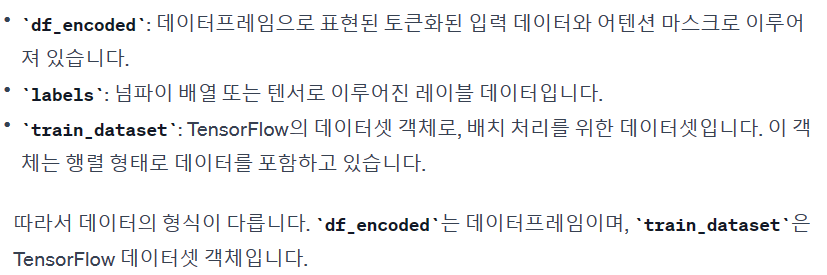

In [ ]:
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# 입력 데이터 형상 확인
print("train_inputs[input_ids] shape:", train_inputs['input_ids'].shape)
print("train_inputs[attention_mask] shape:", train_inputs['attention_mask'].shape)
print("validation_inputs[input_ids] shape:", validation_inputs['input_ids'].shape)
print("validation_inputs[attention_mask] shape:", validation_inputs['attention_mask'].shape)

# 필요한 경우 패딩 또는 트리밍 수행
# 예시: train_inputs['input_ids'] = pad_or_trim(train_inputs['input_ids'], desired_length)

# 모델 학습을 다시 시도


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# 배치 크기 설정
batch_size = 8

# 체크포인트 파일 경로 설정
checkpoint_path = "best_model_clean_roberta"

# ModelCheckpoint 콜백 생성 (Tensorflow SavedModel 형식으로 저장)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_format='tf')

# EarlyStopping 콜백 생성
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')

# 모델 학습을 다시 시도하면서 콜백 추가
history = model.fit(
    train_inputs,
    train_labels,
    epochs=50,  # 에포크 수 증가
    batch_size=batch_size,
    validation_data=(validation_inputs, validation_labels),
    callbacks=[checkpoint, early_stopping]  # 콜백 리스트에 ModelCheckpoint와 EarlyStopping 추가
)


In [ ]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# 검증 데이터에 대한 예측 로짓을 얻음
y_pred_logits = model.predict(validation_inputs).logits

# 로짓을 확률로 변환 (이진 분류 가정)
y_pred_probs = tf.nn.softmax(y_pred_logits, axis=1)[:, 1].numpy()

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(validation_labels, y_pred_probs)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# y_pred_logits의 형태와 처음 몇 개의 로짓 출력
print("Shape of y_pred_logits:", y_pred_logits.shape)
print("Sample logits:", y_pred_logits[:5])

# y_pred_probs의 형태와 처음 몇 개의 확률 출력
print("Shape of y_pred_probs:", y_pred_probs.shape)
print("Sample probabilities:", y_pred_probs[:5])

# ======test set에 대한 검증=======

In [ ]:
# 저장된 모델의 경로
saved_model_path = "best_model_clean_roberta"  # .h5 확장자 제거

# 저장된 모델 불러오기
loaded_model = tf.keras.models.load_model(saved_model_path)

In [ ]:
# test_essays 데이터의 토큰화 진행 상황을 표시
test_input_ids = []
test_attention_masks = []

for text in tqdm(test_essays['text'].tolist(), desc="토큰화 진행중"):
    encoded = tokenizer.encode_plus(text, 
                                    add_special_tokens=True, 
                                    max_length=256, 
                                    padding='max_length', 
                                    truncation=True, 
                                    return_attention_mask=True, 
                                    return_tensors='np')
    test_input_ids.append(encoded['input_ids'][0])
    test_attention_masks.append(encoded['attention_mask'][0])



test_inputs = {
    "input_ids": np.array(test_input_ids),
    "attention_mask": np.array(test_attention_masks)
}  
print("test_inputs shape:", test_inputs["input_ids"].shape)

In [ ]:
# 검증 데이터에 대한 예측 로짓을 얻음
prediction_logits = loaded_model.predict(test_inputs).logits

# 예측 결과를 적절한 형태로 변환
prediction_probs = tf.nn.softmax(prediction_logits, axis=1)[:, 1].numpy()

# 결과를 캐글 제출 형식에 맞게 데이터프레임으로 변환
submission = pd.DataFrame({
    'id': test_essays['id'],  # 샘플 ID
    'prediction': prediction_probs  # 예측 확률
})

# 결과를 CSV 파일로 저장
submission.to_csv('submission_clean_roberta.csv', index=False)
